# Fashion MNIST Image Similarity Search using Triplet Networks


### What is a Triplet Network?
- A neural network that learns to embed images into a feature space
- Uses **triplets** of images: (Anchor, Positive, Negative)
  - **Anchor**: Reference image
  - **Positive**: Image from same class as anchor (similar item)
  - **Negative**: Image from different class (dissimilar item)
- Learns to place similar images close together and dissimilar images far apart

### Goal
Build a system that can:
1. Learn meaningful image representations
2. Find similar fashion items given a query image
3. Recommend similar products based on visual similarity

## Step 1: Import Required Libraries

We'll import all necessary libraries for:
- **PyTorch**: Deep learning framework
- **torchvision**: For dataset handling and transformations
- **NumPy & Pandas**: Data manipulation
- **Matplotlib & Seaborn**: Visualizations
- **scikit-learn**: For t-SNE visualization and metrics

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
from tqdm import tqdm

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# Scikit-learn for metrics and visualization
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Set random seeds for reproducibility
# This ensures we get consistent results across runs
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Fashion MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"Classes: {class_names}")

Using device: cpu
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Step 2: Load Fashion MNIST Dataset

We'll load the dataset from CSV files and prepare it for training:
- Read training and test CSV files
- Separate labels from pixel data
- Normalize pixel values to [0, 1] range
- Convert to PyTorch tensors

In [2]:
print("Loading Fashion MNIST dataset...")
train_df = pd.read_csv('archive (1)/fashion-mnist_train.csv')
test_df = pd.read_csv('archive (1)/fashion-mnist_test.csv')

# Separate labels and pixel data
# First column is the label (0-9), remaining 784 columns are pixel values
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values

test_labels = test_df['label'].values
test_images = test_df.drop('label', axis=1).values

# Reshape from flat array (784,) to image shape (28, 28)
# Then normalize pixel values from [0, 255] to [0, 1] for better training
train_images = train_images.reshape(-1, 28, 28).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28).astype('float32') / 255.0

print(f"Training set: {train_images.shape[0]} images")
print(f"Test set: {test_images.shape[0]} images")
print(f"Image shape: {train_images.shape[1:]} (28x28 grayscale)")
print(f"Number of classes: {len(np.unique(train_labels))}")

# Display class distribution
unique, counts = np.unique(train_labels, return_counts=True)
print("\nClass distribution:")
for label, count in zip(unique, counts):
    print(f"  {label} ({class_names[label]}): {count} samples")

Loading Fashion MNIST dataset...
Training set: 60000 images
Test set: 10000 images
Image shape: (28, 28) (28x28 grayscale)
Number of classes: 10

Class distribution:
  0 (T-shirt/top): 6000 samples
  1 (Trouser): 6000 samples
  2 (Pullover): 6000 samples
  3 (Dress): 6000 samples
  4 (Coat): 6000 samples
  5 (Sandal): 6000 samples
  6 (Shirt): 6000 samples
  7 (Sneaker): 6000 samples
  8 (Bag): 6000 samples
  9 (Ankle boot): 6000 samples
Training set: 60000 images
Test set: 10000 images
Image shape: (28, 28) (28x28 grayscale)
Number of classes: 10

Class distribution:
  0 (T-shirt/top): 6000 samples
  1 (Trouser): 6000 samples
  2 (Pullover): 6000 samples
  3 (Dress): 6000 samples
  4 (Coat): 6000 samples
  5 (Sandal): 6000 samples
  6 (Shirt): 6000 samples
  7 (Sneaker): 6000 samples
  8 (Bag): 6000 samples
  9 (Ankle boot): 6000 samples


## Step 3: Create Triplet Dataset

This is the **core of triplet learning**. We need to create triplets of images:
- **Anchor**: Randomly selected image
- **Positive**: Different image from the SAME class as anchor
- **Negative**: Image from a DIFFERENT class

The network will learn to make anchor-positive distance smaller than anchor-negative distance.

In [3]:
class TripletFashionMNIST(Dataset):
    """
    Custom Dataset class that generates triplets for Fashion MNIST
    
    Each item returns (anchor, positive, negative) tuple where:
    - anchor and positive have the same label
    - negative has a different label
    """
    
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images: numpy array of shape (N, 28, 28) - the image data
            labels: numpy array of shape (N,) - corresponding labels
            transform: optional transforms to apply to images
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        
        # Create a dictionary mapping each label to indices of images with that label
        # This allows efficient sampling of positive and negative examples
        self.label_to_indices = {}
        for idx, label in enumerate(labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)
        
        # Convert lists to numpy arrays for faster indexing
        for label in self.label_to_indices:
            self.label_to_indices[label] = np.array(self.label_to_indices[label])
    
    def __len__(self):
        """Return the total number of samples"""
        return len(self.images)
    
    def __getitem__(self, idx):
        """
        Generate one triplet
        
        Args:
            idx: index of the anchor image
            
        Returns:
            anchor_img: the anchor image tensor (1, 28, 28)
            positive_img: image from same class as anchor (1, 28, 28)
            negative_img: image from different class (1, 28, 28)
        """
        # Get anchor image and its label
        anchor_img = self.images[idx]
        anchor_label = self.labels[idx]
        
        # Select a POSITIVE example: different image with same label as anchor
        # We exclude the anchor itself by removing idx from the choices
        positive_indices = self.label_to_indices[anchor_label]
        # Make sure we don't select the same image as anchor
        positive_indices = positive_indices[positive_indices != idx]
        positive_idx = np.random.choice(positive_indices)
        positive_img = self.images[positive_idx]
        
        # Select a NEGATIVE example: image with different label than anchor
        # First, get all labels different from anchor
        negative_label = np.random.choice(
            [label for label in self.label_to_indices.keys() if label != anchor_label]
        )
        # Then randomly select an image with that label
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_img = self.images[negative_idx]
        
        # Convert images to PyTorch tensors and add channel dimension
        # Shape: (28, 28) -> (1, 28, 28) for grayscale images
        anchor_img = torch.FloatTensor(anchor_img).unsqueeze(0)
        positive_img = torch.FloatTensor(positive_img).unsqueeze(0)
        negative_img = torch.FloatTensor(negative_img).unsqueeze(0)
        
        # Apply transforms if any (e.g., data augmentation)
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img

# Create dataset instances
train_dataset = TripletFashionMNIST(train_images, train_labels)
test_dataset = TripletFashionMNIST(test_images, test_labels)

print(f"Created triplet datasets:")
print(f"  Training triplets: {len(train_dataset)}")
print(f"  Test triplets: {len(test_dataset)}")

# Verify triplet generation - check one sample
anchor, positive, negative = train_dataset[0]
print(f"\nTriplet shapes:")
print(f"  Anchor: {anchor.shape}")
print(f"  Positive: {positive.shape}")
print(f"  Negative: {negative.shape}")

Created triplet datasets:
  Training triplets: 60000
  Test triplets: 10000

Triplet shapes:
  Anchor: torch.Size([1, 28, 28])
  Positive: torch.Size([1, 28, 28])
  Negative: torch.Size([1, 28, 28])


### Visualize Sample Triplets

Let's visualize a few triplets to understand what the network will learn from.

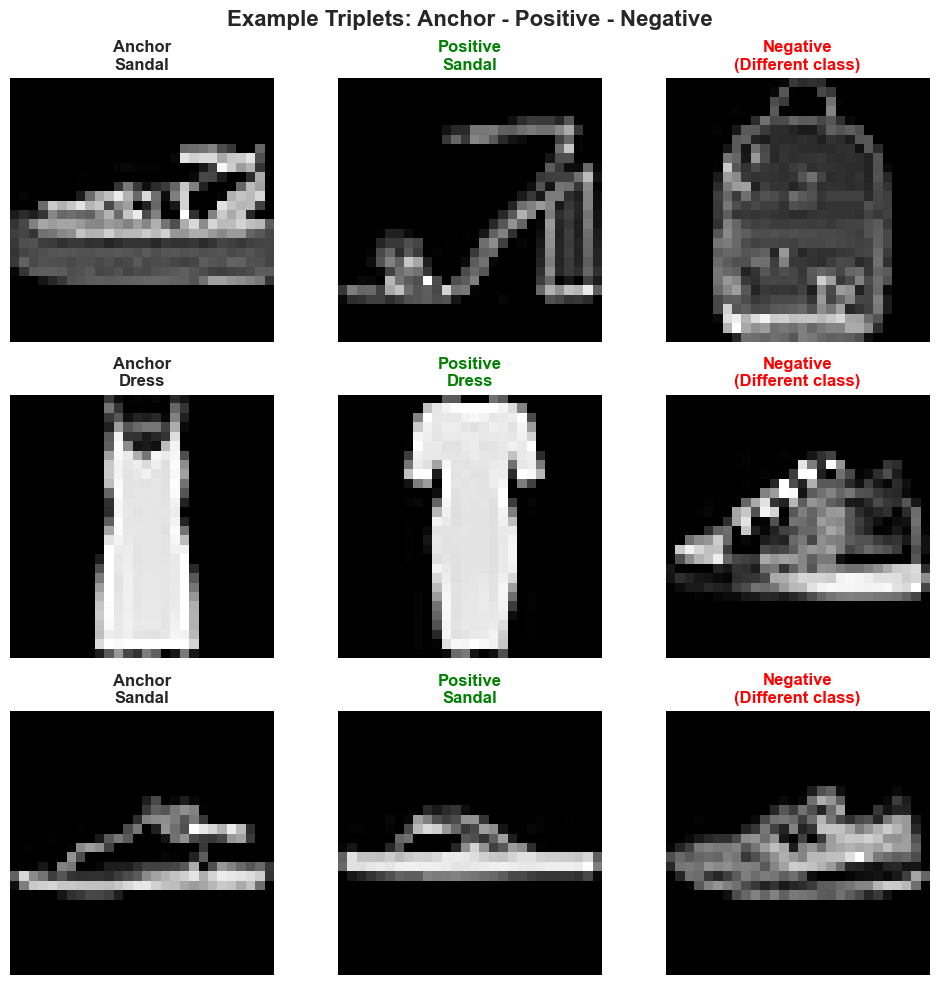

✓ Triplet visualization complete
  • Anchor and Positive should look similar (same category)
  • Negative should look different from Anchor


In [4]:
# Visualize some example triplets
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Example Triplets: Anchor - Positive - Negative', fontsize=16, fontweight='bold')

# Generate 3 random triplets for visualization
for i in range(3):
    # Get a random triplet
    idx = random.randint(0, len(train_dataset) - 1)
    anchor, positive, negative = train_dataset[idx]
    
    # Get labels for display
    anchor_label = train_labels[idx]
    
    # Plot anchor
    axes[i, 0].imshow(anchor.squeeze(), cmap='gray')
    axes[i, 0].set_title(f'Anchor\n{class_names[anchor_label]}', fontweight='bold')
    axes[i, 0].axis('off')
    
    # Plot positive (same class)
    axes[i, 1].imshow(positive.squeeze(), cmap='gray')
    axes[i, 1].set_title(f'Positive\n{class_names[anchor_label]}', fontweight='bold', color='green')
    axes[i, 1].axis('off')
    
    # Plot negative (different class)
    axes[i, 2].imshow(negative.squeeze(), cmap='gray')
    axes[i, 2].set_title(f'Negative\n(Different class)', fontweight='bold', color='red')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Triplet visualization complete")
print("  • Anchor and Positive should look similar (same category)")
print("  • Negative should look different from Anchor")

## Step 4: Define Embedding Network Architecture

The **Embedding Network** is a CNN that converts input images to a compact feature vector (embedding).
- Input: 28x28 grayscale image
- Output: 128-dimensional embedding vector
- Similar images should have similar embeddings (small distance)
- Different images should have different embeddings (large distance)

In [5]:
class EmbeddingNetwork(nn.Module):
    """
    Convolutional Neural Network for learning image embeddings
    
    Architecture:
    - 3 Convolutional blocks (Conv -> ReLU -> MaxPool)
    - Fully connected layers to produce embedding
    - L2 normalization of embeddings
    """
    
    def __init__(self, embedding_dim=128):
        """
        Args:
            embedding_dim: dimension of the output embedding vector (default: 128)
        """
        super(EmbeddingNetwork, self).__init__()
        
        # Convolutional Block 1: Extract low-level features
        # Input: (batch, 1, 28, 28) -> Output: (batch, 32, 14, 14)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),  # Normalize for stable training
            nn.MaxPool2d(2, 2)   # (32, 28, 28) -> (32, 14, 14)
        )
        
        # Convolutional Block 2: Extract mid-level features
        # Input: (batch, 32, 14, 14) -> Output: (batch, 64, 7, 7)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)   # (64, 14, 14) -> (64, 7, 7)
        )
        
        # Convolutional Block 3: Extract high-level features
        # Input: (batch, 64, 7, 7) -> Output: (batch, 128, 3, 3)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (64, 7, 7) -> (128, 7, 7)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)   # (128, 7, 7) -> (128, 3, 3)
        )
        
        # Fully Connected Layers
        # Flatten the conv output: 128 * 3 * 3 = 1152 features
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),  # Dense layer for learning complex patterns
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(256, embedding_dim)  # Final embedding layer
        )
        
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: input image tensor of shape (batch, 1, 28, 28)
            
        Returns:
            embedding: L2-normalized embedding vector of shape (batch, embedding_dim)
        """
        # Pass through convolutional blocks
        x = self.conv1(x)  # (batch, 1, 28, 28) -> (batch, 32, 14, 14)
        x = self.conv2(x)  # (batch, 32, 14, 14) -> (batch, 64, 7, 7)
        x = self.conv3(x)  # (batch, 64, 7, 7) -> (batch, 128, 3, 3)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # (batch, 128, 3, 3) -> (batch, 1152)
        
        # Pass through fully connected layers
        embedding = self.fc(x)  # (batch, 1152) -> (batch, embedding_dim)
        
        # L2 normalization: makes all embeddings have unit length
        # This ensures we can use cosine similarity (just dot product)
        # and makes training more stable
        embedding = F.normalize(embedding, p=2, dim=1)
        
        return embedding

# Create the model and move to device (GPU if available)
model = EmbeddingNetwork(embedding_dim=128).to(device)

# Display model architecture
print("Embedding Network Architecture:")
print("=" * 60)
print(model)
print("=" * 60)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass with dummy data
dummy_input = torch.randn(4, 1, 28, 28).to(device)
dummy_output = model(dummy_input)
print(f"\nTest forward pass:")
print(f"  Input shape: {dummy_input.shape}")
print(f"  Output shape: {dummy_output.shape}")
print(f"  Output embedding dimension: {dummy_output.shape[1]}")

Embedding Network Architecture:
EmbeddingNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_f

## Step 5: Define Triplet Loss Function

**Triplet Loss** is the key to training:
- Formula: `L = max(d(anchor, positive) - d(anchor, negative) + margin, 0)`
- Goal: Make distance between anchor-positive smaller than anchor-negative by at least `margin`
- `margin`: safety buffer to ensure clear separation between similar and dissimilar pairs

In [6]:
class TripletLoss(nn.Module):
    """
    Triplet loss function for learning embeddings
    
    Loss = max(0, distance(anchor, positive) - distance(anchor, negative) + margin)
    
    The goal is to make:
    - distance(anchor, positive) as small as possible
    - distance(anchor, negative) as large as possible
    - with at least 'margin' separation between them
    """
    
    def __init__(self, margin=1.0):
        """
        Args:
            margin: minimum desired separation between positive and negative pairs
        """
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        """
        Calculate triplet loss
        
        Args:
            anchor: embedding of anchor images (batch, embedding_dim)
            positive: embedding of positive images (batch, embedding_dim)
            negative: embedding of negative images (batch, embedding_dim)
            
        Returns:
            loss: scalar triplet loss value
        """
        # Calculate Euclidean distances
        # distance = sqrt(sum((a - b)^2))
        
        # Distance between anchor and positive (should be small)
        pos_distance = F.pairwise_distance(anchor, positive, p=2)
        
        # Distance between anchor and negative (should be large)
        neg_distance = F.pairwise_distance(anchor, negative, p=2)
        
        # Triplet loss: we want pos_distance < neg_distance - margin
        # Rearranging: pos_distance - neg_distance + margin < 0
        # We use ReLU (max with 0) to only penalize violations
        losses = F.relu(pos_distance - neg_distance + self.margin)
        
        # Return mean loss over the batch
        return losses.mean()

# Create loss function with margin=1.0
criterion = TripletLoss(margin=1.0)
print("Triplet Loss Function created")
print(f"  Margin: {criterion.margin}")
print(f"  Goal: distance(anchor, positive) + {criterion.margin} < distance(anchor, negative)")

# Example to illustrate triplet loss
print("\n--- Example Triplet Loss Calculation ---")
# Create dummy embeddings (3 samples, 128 dimensions)
dummy_anchor = torch.randn(3, 128)
dummy_positive = dummy_anchor + torch.randn(3, 128) * 0.1  # Close to anchor
dummy_negative = torch.randn(3, 128)  # Random (likely far from anchor)

# Calculate distances
pos_dist = F.pairwise_distance(dummy_anchor, dummy_positive, p=2)
neg_dist = F.pairwise_distance(dummy_anchor, dummy_negative, p=2)

print(f"Positive distances: {pos_dist.detach().numpy()}")
print(f"Negative distances: {neg_dist.detach().numpy()}")

# Calculate loss
example_loss = criterion(dummy_anchor, dummy_positive, dummy_negative)
print(f"Triplet loss: {example_loss.item():.4f}")

Triplet Loss Function created
  Margin: 1.0
  Goal: distance(anchor, positive) + 1.0 < distance(anchor, negative)

--- Example Triplet Loss Calculation ---
Positive distances: [1.2079556 1.0307906 1.1917548]
Negative distances: [14.53411  15.49271  16.417038]
Triplet loss: 0.0000


## Step 6: Setup Data Loaders and Optimizer

Create data loaders for efficient batch processing and setup the optimizer for training.

In [8]:
# Hyperparameters
BATCH_SIZE = 64  # Number of triplets per batch
LEARNING_RATE = 0.001  # Learning rate for optimizer
NUM_EPOCHS = 15  # Number of training epochs

# Create data loaders
# shuffle=True: randomly shuffle training data each epoch for better generalization
# num_workers=0: use main process for data loading (set to 2-4 for faster loading on multi-core)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # Don't shuffle test data
    num_workers=0
)

print(f"Data Loaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Optimizer: Adam is a good default choice
# It adapts learning rate for each parameter automatically
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler: reduces LR when learning plateaus
# This helps fine-tune the model in later epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',  # Reduce LR when loss stops decreasing
    factor=0.5,  # Multiply LR by 0.5
    patience=2,
)

print(f"\nOptimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")
print(f"\nTraining configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Device: {device}")

Data Loaders created:
  Batch size: 64
  Training batches: 938
  Test batches: 157

Optimizer: Adam
  Learning rate: 0.001
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)

Training configuration:
  Epochs: 15
  Device: cpu


## Step 7: Training and Validation Functions

We'll create functions to:
1. **Train**: Process batches, compute loss, update weights
2. **Validate**: Evaluate model on test set without updating weights
3. **Calculate Accuracy**: Measure how well embeddings separate similar/dissimilar pairs

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    
    Args:
        model: the embedding network
        train_loader: DataLoader for training data
        criterion: triplet loss function
        optimizer: optimizer for updating weights
        device: CPU or GPU
        
    Returns:
        avg_loss: average loss over all batches
        accuracy: percentage of triplets where d(anchor,positive) < d(anchor,negative)
    """
    # Set model to training mode
    # This enables dropout and batch normalization training behavior
    model.train()
    
    total_loss = 0.0
    correct_triplets = 0
    total_triplets = 0
    
    # Iterate through batches with progress bar
    for batch_idx, (anchor, positive, negative) in enumerate(tqdm(train_loader, desc="Training")):
        # Move data to device (GPU if available)
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        
        # Forward pass: get embeddings for all three images
        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)
        
        # Calculate triplet loss
        loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track loss
        total_loss += loss.item()
        
        # Calculate accuracy: count triplets where d(a,p) < d(a,n)
        # This means the network correctly separates similar from dissimilar
        with torch.no_grad():
            pos_dist = F.pairwise_distance(anchor_embedding, positive_embedding)
            neg_dist = F.pairwise_distance(anchor_embedding, negative_embedding)
            correct = (pos_dist < neg_dist).sum().item()
            correct_triplets += correct
            total_triplets += anchor.size(0)
    
    # Calculate averages
    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct_triplets / total_triplets
    
    return avg_loss, accuracy


def validate_epoch(model, test_loader, criterion, device):
    """
    Validate the model on test set
    
    Args:
        model: the embedding network
        test_loader: DataLoader for test data
        criterion: triplet loss function
        device: CPU or GPU
        
    Returns:
        avg_loss: average validation loss
        accuracy: validation accuracy (% of correct triplet orderings)
    """
    # Set model to evaluation mode
    # This disables dropout and uses batch norm running statistics
    model.eval()
    
    total_loss = 0.0
    correct_triplets = 0
    total_triplets = 0
    
    # Disable gradient computation for validation (saves memory and time)
    with torch.no_grad():
        for anchor, positive, negative in tqdm(test_loader, desc="Validation"):
            # Move to device
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            # Forward pass
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)
            
            # Calculate loss
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            total_loss += loss.item()
            
            # Calculate accuracy
            pos_dist = F.pairwise_distance(anchor_embedding, positive_embedding)
            neg_dist = F.pairwise_distance(anchor_embedding, negative_embedding)
            correct = (pos_dist < neg_dist).sum().item()
            correct_triplets += correct
            total_triplets += anchor.size(0)
    
    # Calculate averages
    avg_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct_triplets / total_triplets
    
    return avg_loss, accuracy

print("✓ Training and validation functions defined")
print("  • train_epoch(): trains model for one epoch")
print("  • validate_epoch(): evaluates model on test set")
print("  • Accuracy metric: % of triplets where d(anchor,positive) < d(anchor,negative)")

✓ Training and validation functions defined
  • train_epoch(): trains model for one epoch
  • validate_epoch(): evaluates model on test set
  • Accuracy metric: % of triplets where d(anchor,positive) < d(anchor,negative)


## Step 8: Train the Model

Now we'll train the model and track metrics over epochs.

In [10]:
# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Track best model
best_val_loss = float('inf')
best_epoch = 0

print("=" * 70)
print("TRAINING TRIPLET NETWORK")
print("=" * 70)

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print("-" * 70)
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Accuracy:   {val_acc:.2f}%")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_triplet_model.pth')
        print(f"  ✓ New best model saved! (Val Loss: {val_loss:.4f})")

print("\n" + "=" * 70)
print("TRAINING COMPLETED!")
print("=" * 70)
print(f"Best model from epoch {best_epoch} with validation loss: {best_val_loss:.4f}")
print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")

TRAINING TRIPLET NETWORK

Epoch [1/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:07<00:00, 19.74it/s]



Epoch 1 Summary:
  Train Loss: 0.2154 | Train Accuracy: 92.98%
  Val Loss:   0.1470 | Val Accuracy:   95.52%
  ✓ New best model saved! (Val Loss: 0.1470)

Epoch [2/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.75it/s]



Epoch 2 Summary:
  Train Loss: 0.1344 | Train Accuracy: 95.86%
  Val Loss:   0.1186 | Val Accuracy:   96.85%
  ✓ New best model saved! (Val Loss: 0.1186)

Epoch [3/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:07<00:00, 20.15it/s]



Epoch 3 Summary:
  Train Loss: 0.1176 | Train Accuracy: 96.75%
  Val Loss:   0.1215 | Val Accuracy:   96.72%

Epoch [4/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:10<00:00, 15.67it/s]




Epoch 4 Summary:
  Train Loss: 0.1089 | Train Accuracy: 97.21%
  Val Loss:   0.1053 | Val Accuracy:   97.31%
  ✓ New best model saved! (Val Loss: 0.1053)

Epoch [5/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.36it/s]




Epoch 5 Summary:
  Train Loss: 0.0978 | Train Accuracy: 97.59%
  Val Loss:   0.1021 | Val Accuracy:   97.47%
  ✓ New best model saved! (Val Loss: 0.1021)

Epoch [6/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 14.15it/s]



Epoch 6 Summary:
  Train Loss: 0.0903 | Train Accuracy: 97.84%
  Val Loss:   0.0989 | Val Accuracy:   97.53%
  ✓ New best model saved! (Val Loss: 0.0989)

Epoch [7/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:12<00:00, 12.63it/s]



Epoch 7 Summary:
  Train Loss: 0.0840 | Train Accuracy: 98.09%
  Val Loss:   0.0970 | Val Accuracy:   97.72%
  ✓ New best model saved! (Val Loss: 0.0970)

Epoch [8/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.74it/s]



Epoch 8 Summary:
  Train Loss: 0.0817 | Train Accuracy: 98.02%
  Val Loss:   0.0994 | Val Accuracy:   97.57%

Epoch [9/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.02it/s]




Epoch 9 Summary:
  Train Loss: 0.0787 | Train Accuracy: 98.18%
  Val Loss:   0.0992 | Val Accuracy:   97.72%

Epoch [10/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:07<00:00, 20.21it/s]



Epoch 10 Summary:
  Train Loss: 0.0738 | Train Accuracy: 98.44%
  Val Loss:   0.0972 | Val Accuracy:   97.73%

Epoch [11/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:07<00:00, 20.09it/s]




Epoch 11 Summary:
  Train Loss: 0.0616 | Train Accuracy: 98.59%
  Val Loss:   0.0897 | Val Accuracy:   97.61%
  ✓ New best model saved! (Val Loss: 0.0897)

Epoch [12/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:08<00:00, 18.76it/s]



Epoch 12 Summary:
  Train Loss: 0.0597 | Train Accuracy: 98.66%
  Val Loss:   0.0860 | Val Accuracy:   97.93%
  ✓ New best model saved! (Val Loss: 0.0860)

Epoch [13/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:08<00:00, 19.21it/s]



Epoch 13 Summary:
  Train Loss: 0.0564 | Train Accuracy: 98.76%
  Val Loss:   0.0854 | Val Accuracy:   97.80%
  ✓ New best model saved! (Val Loss: 0.0854)

Epoch [14/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:08<00:00, 17.99it/s]




Epoch 14 Summary:
  Train Loss: 0.0519 | Train Accuracy: 98.83%
  Val Loss:   0.0901 | Val Accuracy:   97.71%

Epoch [15/15]
----------------------------------------------------------------------


Validation: 100%|██████████| 157/157 [00:08<00:00, 19.37it/s]


Epoch 15 Summary:
  Train Loss: 0.0524 | Train Accuracy: 98.93%
  Val Loss:   0.0911 | Val Accuracy:   97.64%

TRAINING COMPLETED!
Best model from epoch 13 with validation loss: 0.0854
Final training accuracy: 98.93%
Final validation accuracy: 97.64%


## Step 9: Visualize Training Progress

Plot the training and validation metrics to understand model performance.

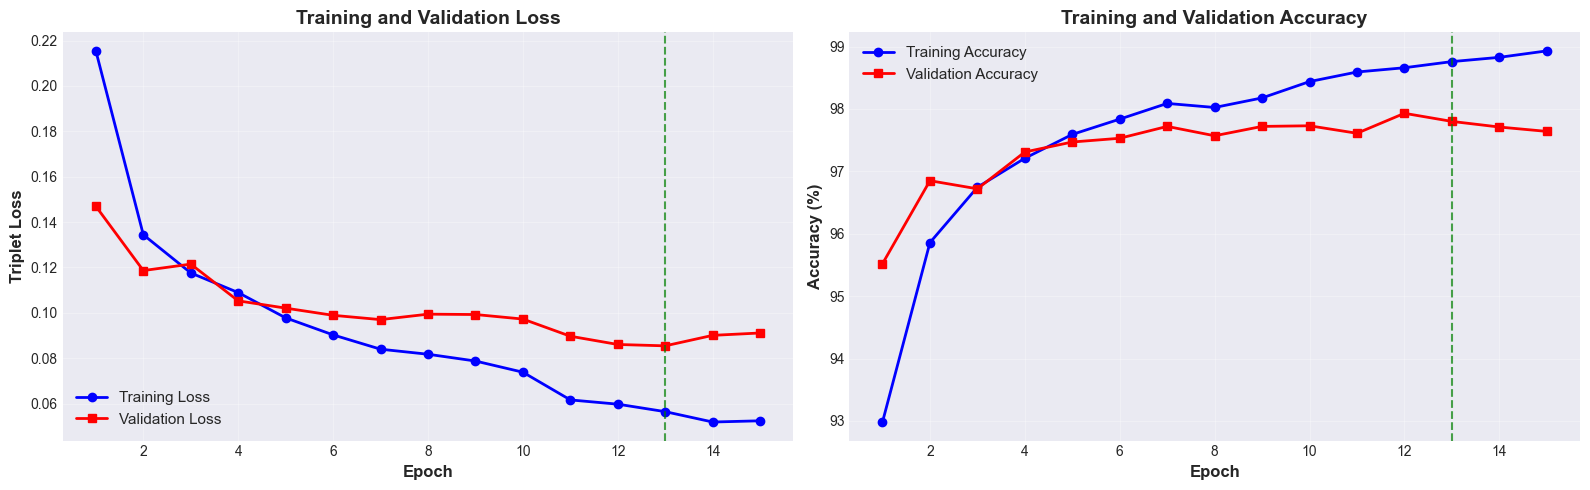


FINAL METRICS SUMMARY
Training Loss:   0.2154 → 0.0524 (Δ 0.1630)
Validation Loss: 0.1470 → 0.0911 (Δ 0.0559)

Training Accuracy:   92.98% → 98.93% (Δ +5.95%)
Validation Accuracy: 95.52% → 97.64% (Δ +2.12%)


In [11]:
# Create comprehensive training visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Loss over epochs
axes[0].plot(range(1, NUM_EPOCHS+1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(range(1, NUM_EPOCHS+1), val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Triplet Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Model (Epoch {best_epoch})', alpha=0.7)

# Plot 2: Accuracy over epochs
axes[1].plot(range(1, NUM_EPOCHS+1), train_accuracies, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(range(1, NUM_EPOCHS+1), val_accuracies, 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Model (Epoch {best_epoch})', alpha=0.7)

plt.tight_layout()
plt.show()

# Print final metrics summary
print("\n" + "=" * 60)
print("FINAL METRICS SUMMARY")
print("=" * 60)
print(f"Training Loss:   {train_losses[0]:.4f} → {train_losses[-1]:.4f} (Δ {train_losses[0]-train_losses[-1]:.4f})")
print(f"Validation Loss: {val_losses[0]:.4f} → {val_losses[-1]:.4f} (Δ {val_losses[0]-val_losses[-1]:.4f})")
print(f"\nTraining Accuracy:   {train_accuracies[0]:.2f}% → {train_accuracies[-1]:.2f}% (Δ +{train_accuracies[-1]-train_accuracies[0]:.2f}%)")
print(f"Validation Accuracy: {val_accuracies[0]:.2f}% → {val_accuracies[-1]:.2f}% (Δ +{val_accuracies[-1]-val_accuracies[0]:.2f}%)")
print("=" * 60)

## Step 10: Extract Embeddings for Similarity Search

To build a recommendation system, we need to:
1. Extract embeddings for all images in the dataset
2. Store them for fast similarity search

In [12]:
def extract_embeddings(model, images, device, batch_size=128):
    """
    Extract embeddings for a set of images
    
    Args:
        model: trained embedding network
        images: numpy array of images (N, 28, 28)
        device: CPU or GPU
        batch_size: batch size for processing
        
    Returns:
        embeddings: numpy array of embeddings (N, embedding_dim)
    """
    model.eval()  # Set to evaluation mode
    embeddings = []
    
    # Process in batches to avoid memory issues
    num_images = len(images)
    with torch.no_grad():
        for i in tqdm(range(0, num_images, batch_size), desc="Extracting embeddings"):
            # Get batch
            batch = images[i:i+batch_size]
            
            # Convert to tensor and add channel dimension
            batch_tensor = torch.FloatTensor(batch).unsqueeze(1).to(device)
            
            # Get embeddings
            batch_embeddings = model(batch_tensor)
            
            # Move to CPU and convert to numpy
            embeddings.append(batch_embeddings.cpu().numpy())
    
    # Concatenate all batches
    embeddings = np.vstack(embeddings)
    return embeddings

# Extract embeddings for training and test sets
print("Extracting embeddings for all images...")
print("This may take a few minutes...\n")

train_embeddings = extract_embeddings(model, train_images, device)
test_embeddings = extract_embeddings(model, test_images, device)

print(f"\n✓ Embeddings extracted:")
print(f"  Training set: {train_embeddings.shape}")
print(f"  Test set: {test_embeddings.shape}")
print(f"  Embedding dimension: {train_embeddings.shape[1]}")

# Verify embeddings are normalized (should have unit length)
sample_norms = np.linalg.norm(train_embeddings[:5], axis=1)
print(f"\nSample embedding norms (should be ~1.0): {sample_norms}")

Extracting embeddings for all images...
This may take a few minutes...



Extracting embeddings: 100%|██████████| 79/79 [00:01<00:00, 42.09it/s]


✓ Embeddings extracted:
  Training set: (60000, 128)
  Test set: (10000, 128)
  Embedding dimension: 128

Sample embedding norms (should be ~1.0): [1. 1. 1. 1. 1.]


## Step 11: Build Image Similarity Search Function

Now we can find similar images using cosine similarity:
- Since embeddings are L2-normalized, cosine similarity = dot product
- Higher similarity = more similar images

In [13]:
def find_similar_images(query_idx, embeddings, labels, images, top_k=10):
    """
    Find the most similar images to a query image
    
    Args:
        query_idx: index of query image
        embeddings: all image embeddings (N, embedding_dim)
        labels: all image labels (N,)
        images: all images (N, 28, 28)
        top_k: number of similar images to return
        
    Returns:
        similar_indices: indices of top_k most similar images
        similarities: similarity scores for those images
    """
    # Get query embedding
    query_embedding = embeddings[query_idx:query_idx+1]  # Shape: (1, embedding_dim)
    
    # Calculate cosine similarities with all images
    # Since embeddings are L2-normalized, cosine similarity = dot product
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    
    # Get top-k most similar (including the query itself)
    # argsort returns indices sorted by similarity (ascending)
    # We reverse it with [::-1] to get descending order
    similar_indices = np.argsort(similarities)[::-1][:top_k+1]
    
    # Remove the query itself (it will be the most similar)
    similar_indices = similar_indices[similar_indices != query_idx][:top_k]
    
    return similar_indices, similarities[similar_indices]


def calculate_retrieval_accuracy(embeddings, labels, k=10):
    """
    Calculate retrieval accuracy: how often do top-k results include same-class items?
    
    Args:
        embeddings: image embeddings
        labels: true labels
        k: number of neighbors to consider
        
    Returns:
        accuracy: average percentage of same-class items in top-k
    """
    num_samples = len(embeddings)
    same_class_counts = []
    
    for i in range(num_samples):
        # Find k most similar images
        similar_indices, _ = find_similar_images(i, embeddings, labels, None, top_k=k)
        
        # Count how many have the same label as query
        query_label = labels[i]
        same_class = np.sum(labels[similar_indices] == query_label)
        same_class_counts.append(same_class)
    
    # Calculate average accuracy
    avg_accuracy = 100.0 * np.mean(same_class_counts) / k
    return avg_accuracy

# Calculate retrieval accuracy on test set
print("Calculating retrieval accuracy on test set...")
retrieval_acc_k5 = calculate_retrieval_accuracy(test_embeddings, test_labels, k=5)
retrieval_acc_k10 = calculate_retrieval_accuracy(test_embeddings, test_labels, k=10)

print(f"\n✓ Retrieval Accuracy:")
print(f"  Top-5:  {retrieval_acc_k5:.2f}% (on average, {retrieval_acc_k5/100*5:.1f}/5 retrieved items are from same class)")
print(f"  Top-10: {retrieval_acc_k10:.2f}% (on average, {retrieval_acc_k10/100*10:.1f}/10 retrieved items are from same class)")
print(f"\nThis means the model successfully retrieves similar fashion items!")

Calculating retrieval accuracy on test set...

✓ Retrieval Accuracy:
  Top-5:  89.76% (on average, 4.5/5 retrieved items are from same class)
  Top-10: 89.78% (on average, 9.0/10 retrieved items are from same class)

This means the model successfully retrieves similar fashion items!

✓ Retrieval Accuracy:
  Top-5:  89.76% (on average, 4.5/5 retrieved items are from same class)
  Top-10: 89.78% (on average, 9.0/10 retrieved items are from same class)

This means the model successfully retrieves similar fashion items!


## Step 12: Visualize Recommendations

Let's visualize the recommendation system in action!

IMAGE SIMILARITY RECOMMENDATIONS
Green = Same class | Red = Different class


--- Recommendation 1 ---


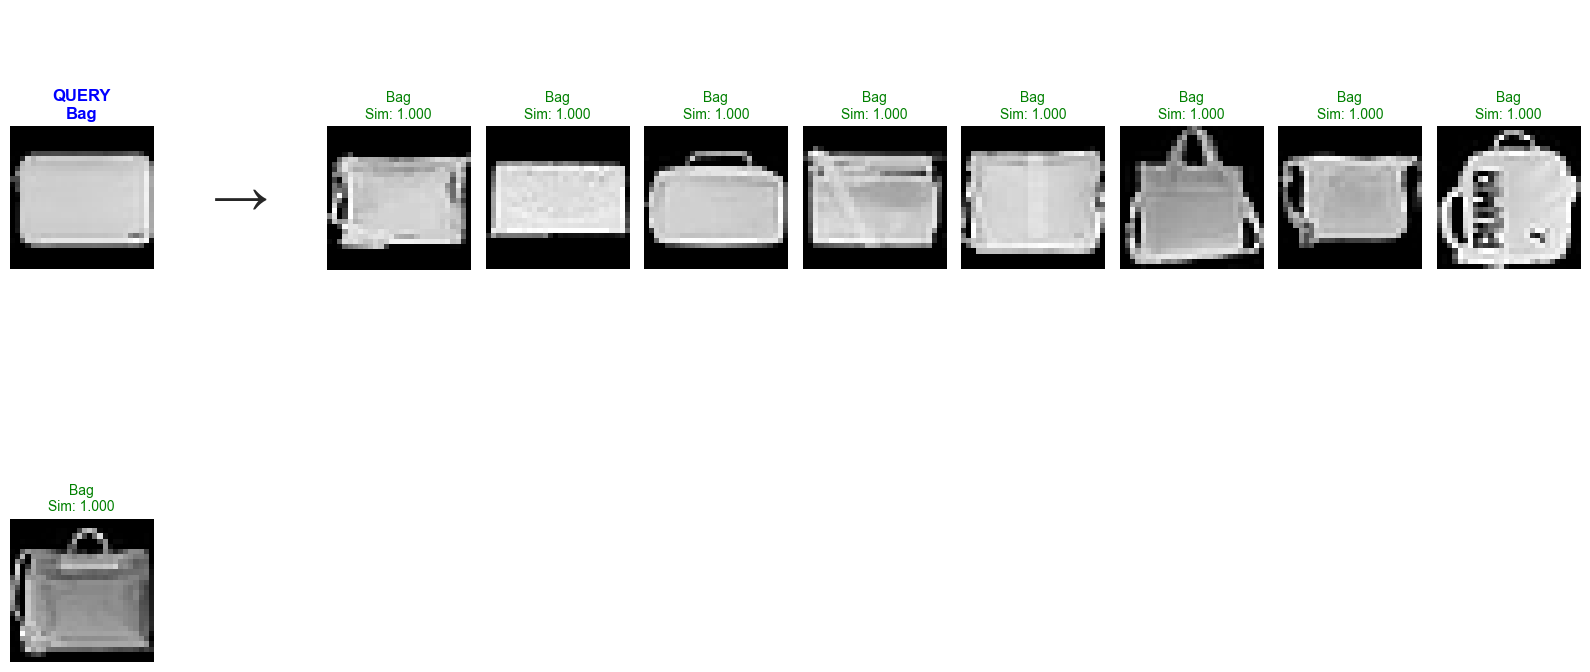

Query: Bag
Retrieved 9/9 items from the same class
Average similarity score: 1.000


--- Recommendation 2 ---


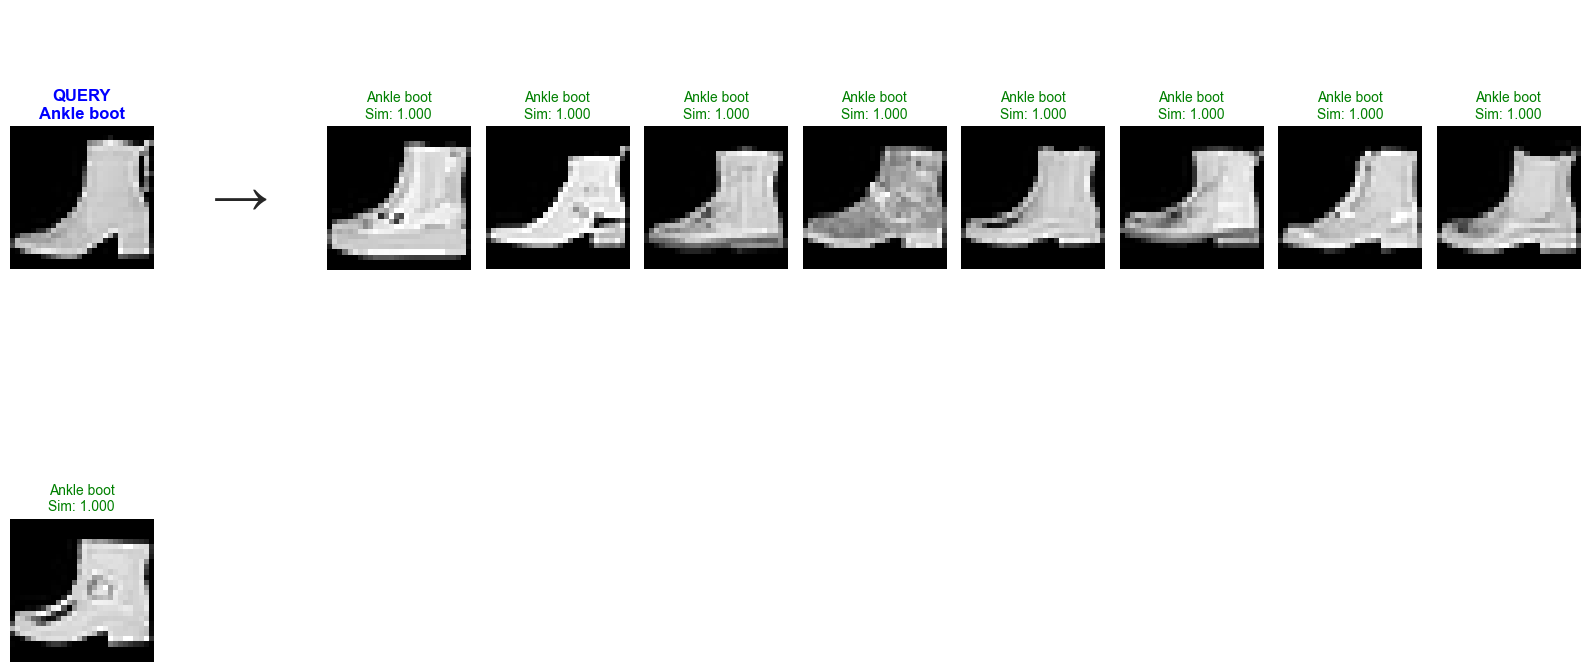

Query: Ankle boot
Retrieved 9/9 items from the same class
Average similarity score: 1.000


--- Recommendation 3 ---


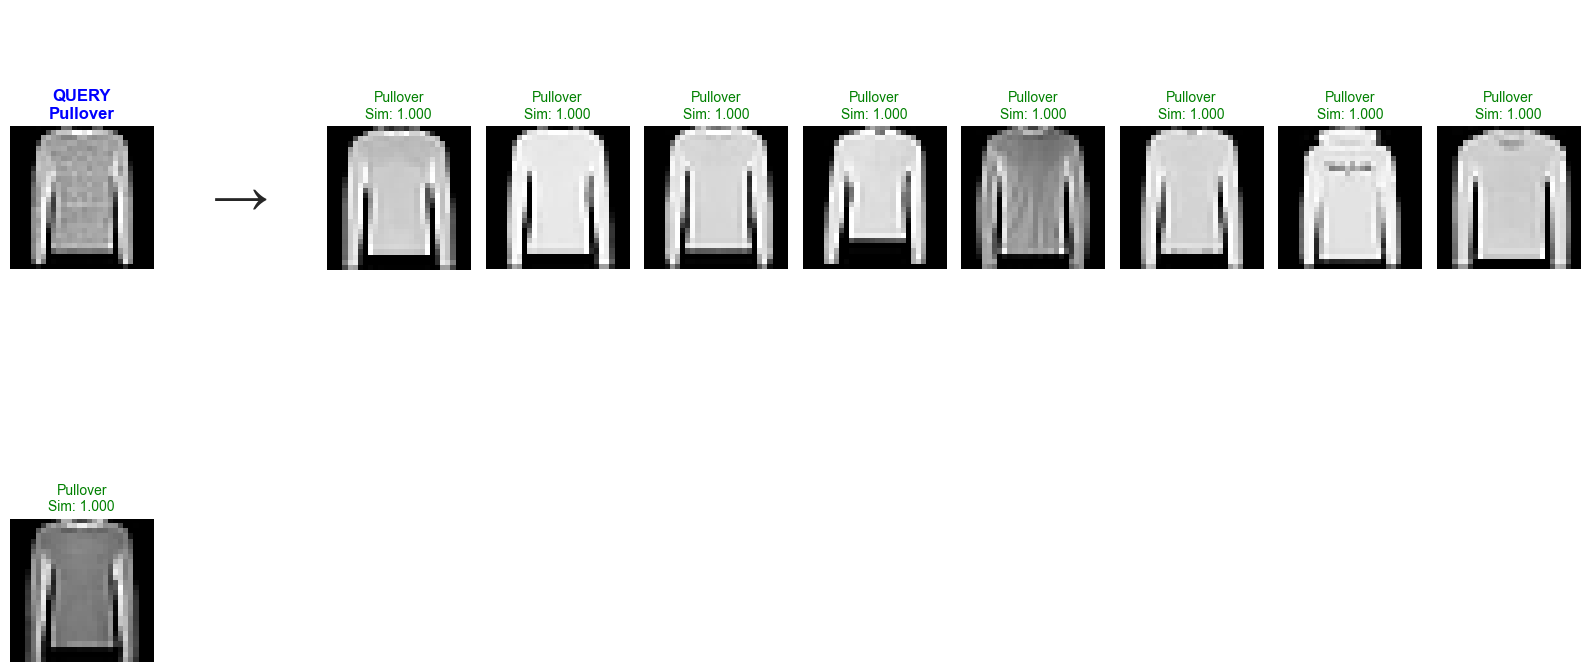

Query: Pullover
Retrieved 9/9 items from the same class
Average similarity score: 1.000


--- Recommendation 4 ---


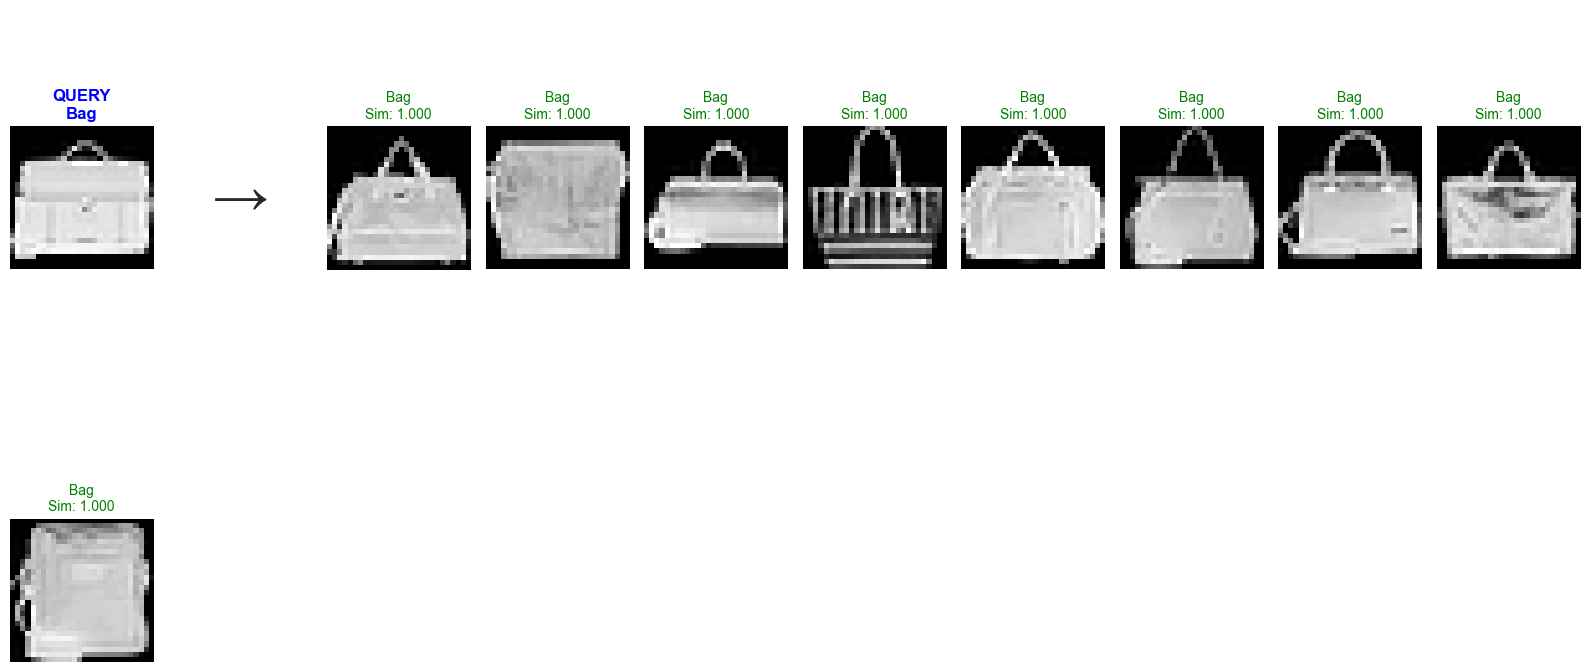

Query: Bag
Retrieved 9/9 items from the same class
Average similarity score: 1.000


--- Recommendation 5 ---


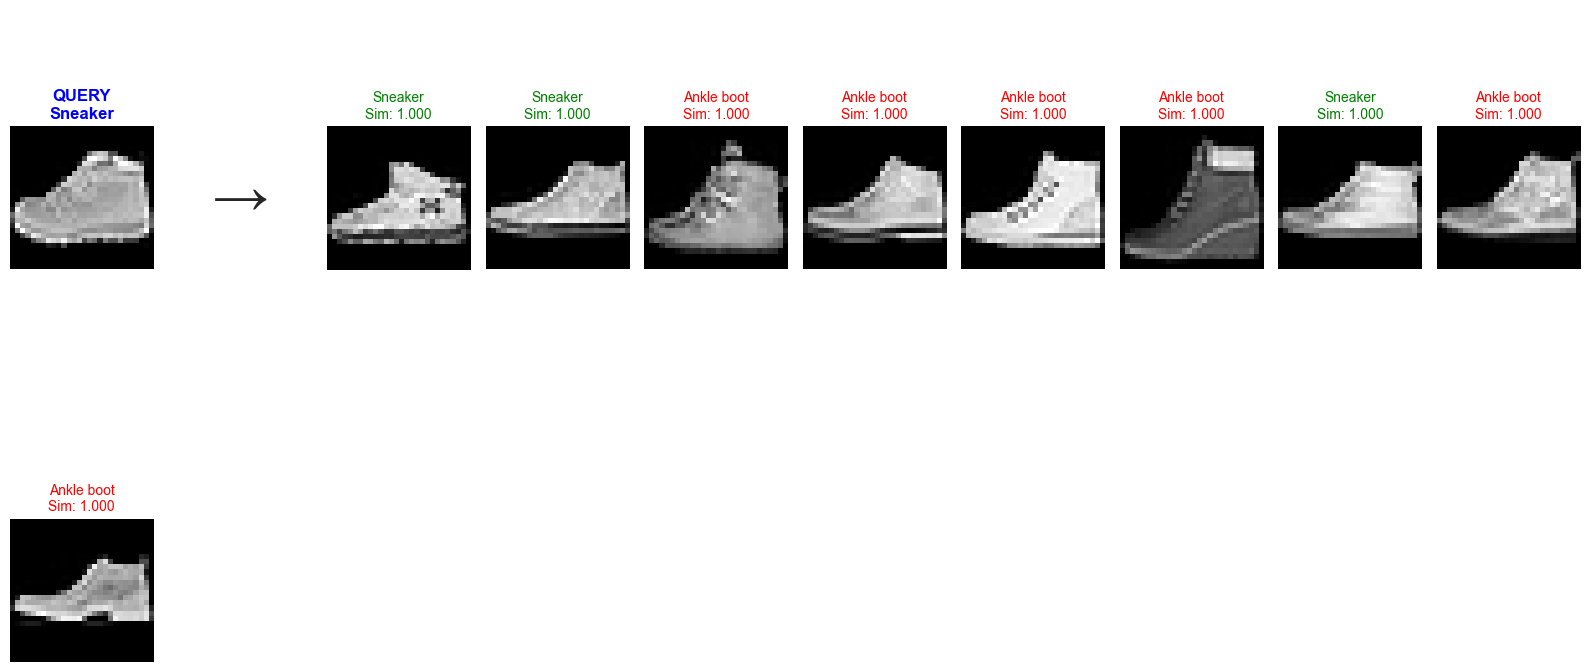

Query: Sneaker
Retrieved 3/9 items from the same class
Average similarity score: 1.000



In [14]:
def visualize_recommendations(query_idx, embeddings, labels, images, top_k=9):
    """
    Visualize query image and its most similar recommendations
    
    Args:
        query_idx: index of query image
        embeddings: image embeddings
        labels: image labels
        images: image data
        top_k: number of recommendations to show
    """
    # Get query info
    query_image = images[query_idx]
    query_label = labels[query_idx]
    
    # Find similar images
    similar_indices, similarities = find_similar_images(
        query_idx, embeddings, labels, images, top_k=top_k
    )
    
    # Create visualization
    fig = plt.figure(figsize=(16, 8))
    
    # Create grid: 2 rows, top_k+1 columns
    # Top row: Query image + top recommendations
    # Bottom row: Similarity scores
    
    # Plot query image
    ax = plt.subplot(2, top_k+1, 1)
    ax.imshow(query_image, cmap='gray')
    ax.set_title(f'QUERY\n{class_names[query_label]}', 
                 fontsize=12, fontweight='bold', color='blue')
    ax.axis('off')
    
    # Add arrow
    plt.subplot(2, top_k+1, 2)
    plt.text(0.5, 0.5, '→', fontsize=40, ha='center', va='center')
    plt.axis('off')
    
    # Plot similar images
    for i, (sim_idx, similarity) in enumerate(zip(similar_indices, similarities)):
        ax = plt.subplot(2, top_k+1, i+3)
        ax.imshow(images[sim_idx], cmap='gray')
        
        # Color code: green if same class, red if different
        sim_label = labels[sim_idx]
        color = 'green' if sim_label == query_label else 'red'
        
        ax.set_title(f'{class_names[sim_label]}\nSim: {similarity:.3f}', 
                    fontsize=10, color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    same_class_count = np.sum(labels[similar_indices] == query_label)
    print(f"Query: {class_names[query_label]}")
    print(f"Retrieved {same_class_count}/{top_k} items from the same class")
    print(f"Average similarity score: {np.mean(similarities):.3f}")


# Visualize recommendations for random test images
print("=" * 70)
print("IMAGE SIMILARITY RECOMMENDATIONS")
print("=" * 70)
print("Green = Same class | Red = Different class\n")

# Show recommendations for 5 random test images
for i in range(5):
    query_idx = random.randint(0, len(test_images) - 1)
    print(f"\n--- Recommendation {i+1} ---")
    visualize_recommendations(query_idx, test_embeddings, test_labels, test_images, top_k=9)
    print()

## Step 13: Visualize Embedding Space with t-SNE

**t-SNE** (t-Distributed Stochastic Neighbor Embedding) reduces high-dimensional embeddings to 2D for visualization:
- Similar items should cluster together
- Different items should be separated
- This shows if the model learned meaningful representations

Applying t-SNE to 5000 test samples...
This may take 1-2 minutes...


✓ t-SNE completed!

✓ t-SNE completed!


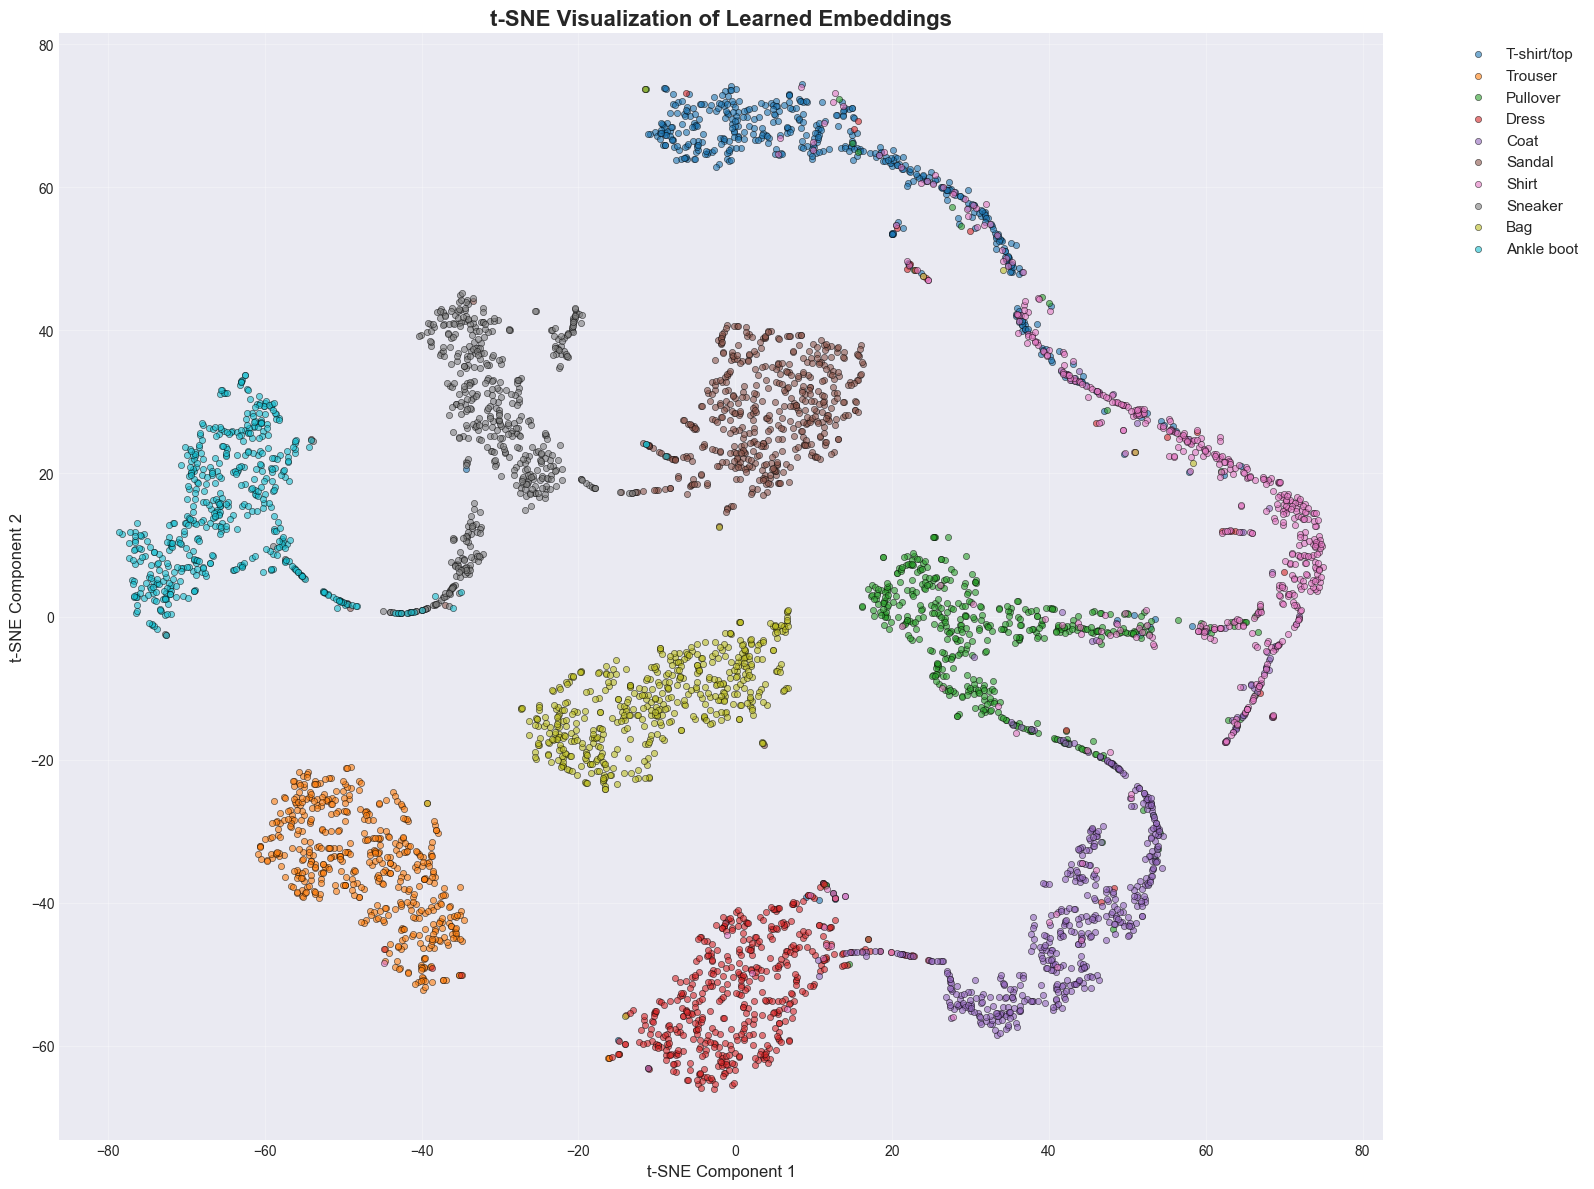


EMBEDDING SPACE ANALYSIS
Good clustering indicates the model learned to:
  ✓ Group similar fashion items together
  ✓ Separate different categories
  ✓ Create meaningful visual representations

Look for:
  • Tight clusters → Same class items are similar
  • Clear separation → Different classes are distinguishable
  • Some overlap is normal (e.g., T-shirts vs Shirts)


In [17]:
# Sample a subset for visualization (t-SNE is slow on large datasets)
# We'll use 5000 random test samples
np.random.seed(42)
sample_size = 5000
sample_indices = np.random.choice(len(test_embeddings), sample_size, replace=False)

sample_embeddings = test_embeddings[sample_indices]
sample_labels = test_labels[sample_indices]

print(f"Applying t-SNE to {sample_size} test samples...")
print("This may take 1-2 minutes...\n")

# Apply t-SNE
# perplexity: balance between local and global structure (typical: 30-50)
# n_iter: number of iterations (more = better quality but slower)
tsne = TSNE(
    n_components=2,      # Reduce to 2D
    perplexity=30,       # Consider 30 neighbors
    random_state=42,
    max_iter=1000
)

embeddings_2d = tsne.fit_transform(sample_embeddings)

print("\n✓ t-SNE completed!")

# Create visualization
plt.figure(figsize=(16, 12))

# Define colors for each class
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot each class with different color
for class_idx in range(10):
    # Get points belonging to this class
    mask = sample_labels == class_idx
    points = embeddings_2d[mask]
    
    # Plot with class-specific color
    plt.scatter(
        points[:, 0], 
        points[:, 1], 
        c=[colors[class_idx]], 
        label=class_names[class_idx],
        alpha=0.6,
        s=20,
        edgecolors='black',
        linewidth=0.5
    )

plt.title('t-SNE Visualization of Learned Embeddings', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("EMBEDDING SPACE ANALYSIS")
print("=" * 70)
print("Good clustering indicates the model learned to:")
print("  ✓ Group similar fashion items together")
print("  ✓ Separate different categories")
print("  ✓ Create meaningful visual representations")
print("\nLook for:")
print("  • Tight clusters → Same class items are similar")
print("  • Clear separation → Different classes are distinguishable")
print("  • Some overlap is normal (e.g., T-shirts vs Shirts)")
print("=" * 70)

## Step 14: Class-wise Performance Analysis

Analyze which classes are easiest/hardest for the model to distinguish.

Calculating per-class retrieval accuracy...


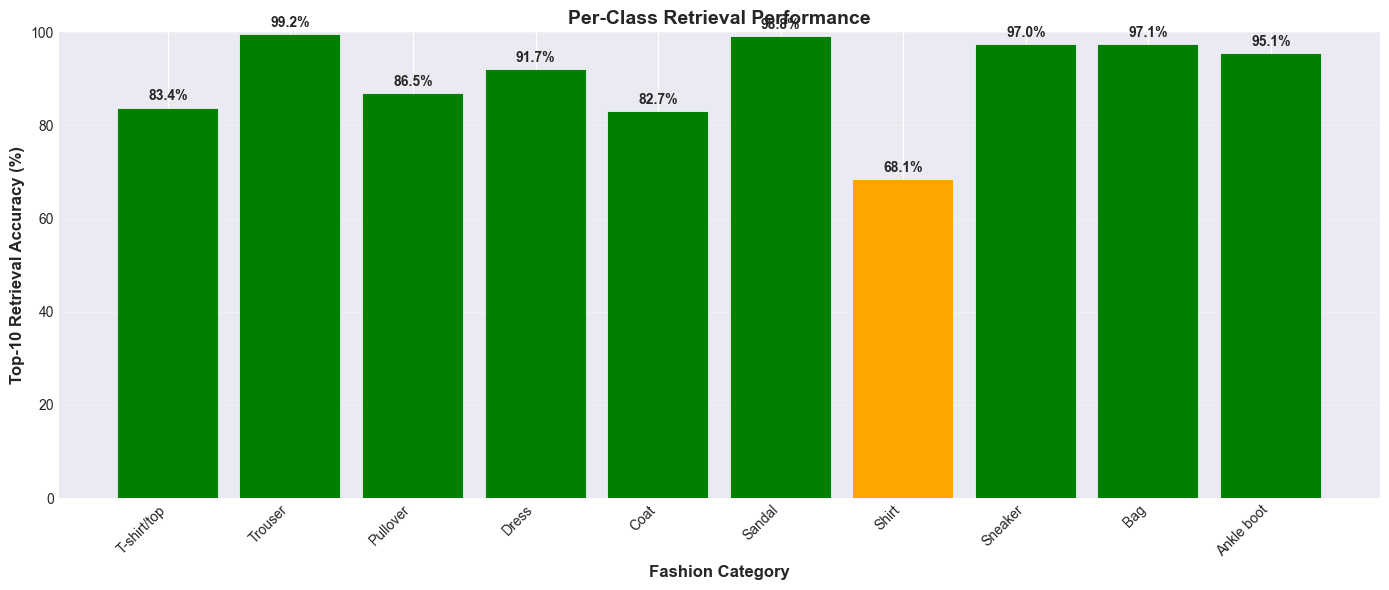


PER-CLASS RETRIEVAL ACCURACY (Top-10)
T-shirt/top    :  83.4%  ✓ Excellent
Trouser        :  99.2%  ✓ Excellent
Pullover       :  86.5%  ✓ Excellent
Dress          :  91.7%  ✓ Excellent
Coat           :  82.7%  ✓ Excellent
Sandal         :  98.8%  ✓ Excellent
Shirt          :  68.1%  ○ Good
Sneaker        :  97.0%  ✓ Excellent
Bag            :  97.1%  ✓ Excellent
Ankle boot     :  95.1%  ✓ Excellent

Average Accuracy: 90.0%

Best performing:  Trouser (99.2%)
Worst performing: Shirt (68.1%)


In [18]:
# Calculate retrieval accuracy for each class separately
print("Calculating per-class retrieval accuracy...")

class_accuracies = []
k = 10  # Top-10 retrieval

for class_idx in range(10):
    # Get all images of this class
    class_mask = test_labels == class_idx
    class_indices = np.where(class_mask)[0]
    
    # Calculate accuracy for this class
    same_class_counts = []
    for idx in class_indices[:100]:  # Sample 100 per class for speed
        similar_indices, _ = find_similar_images(
            idx, test_embeddings, test_labels, test_images, top_k=k
        )
        same_class = np.sum(test_labels[similar_indices] == class_idx)
        same_class_counts.append(same_class)
    
    accuracy = 100.0 * np.mean(same_class_counts) / k
    class_accuracies.append(accuracy)

# Create bar plot
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(range(10), class_accuracies, color='steelblue', edgecolor='black', linewidth=1.5)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, class_accuracies)):
    if acc >= 80:
        bar.set_color('green')
    elif acc >= 60:
        bar.set_color('orange')
    else:
        bar.set_color('red')

ax.set_xlabel('Fashion Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Top-10 Retrieval Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Retrieval Performance', fontsize=14, fontweight='bold')
ax.set_xticks(range(10))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 100])

# Add value labels on bars
for i, acc in enumerate(class_accuracies):
    ax.text(i, acc + 2, f'{acc:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 70)
print("PER-CLASS RETRIEVAL ACCURACY (Top-10)")
print("=" * 70)
for i, acc in enumerate(class_accuracies):
    status = "✓ Excellent" if acc >= 80 else "○ Good" if acc >= 60 else "✗ Needs Improvement"
    print(f"{class_names[i]:15s}: {acc:5.1f}%  {status}")

avg_accuracy = np.mean(class_accuracies)
print(f"\nAverage Accuracy: {avg_accuracy:.1f}%")
print("=" * 70)

# Find best and worst performing classes
best_class = np.argmax(class_accuracies)
worst_class = np.argmin(class_accuracies)
print(f"\nBest performing:  {class_names[best_class]} ({class_accuracies[best_class]:.1f}%)")
print(f"Worst performing: {class_names[worst_class]} ({class_accuracies[worst_class]:.1f}%)")